# Обучение моделей в Pytorch

In [49]:
import os
import random
from os.path import join as pjoin
from shutil import rmtree

import albumentations
import numpy as np
import torch
from accelerate import Accelerator
from albumentations.pytorch.transforms import ToTensorV2
from dataset import CustomDataset
from matplotlib import pyplot as plt
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from train import (
    CheckpointSaver,
    IoUMetric,
    MulticlassCrossEntropyLoss,
    MulticlassDiceLoss,
    load_checkpoint,
    train,
)
from unet import UNet, count_model_params

In [50]:
def seed_everything(seed: int = 314159, torch_deterministic: bool = False) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(torch_deterministic)


seed_everything(42, torch_deterministic=False)

## Аугментации

In [51]:
IMAGE_SIZE = 256
transforms = albumentations.Compose(
    [
        albumentations.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        albumentations.AdvancedBlur(p=0.5),
        albumentations.GaussNoise(p=0.5),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.CLAHE(p=0.5),
        albumentations.RandomBrightnessContrast(p=0.5),
        albumentations.RandomGamma(p=0.5),
        albumentations.ColorJitter(p=0.5),
        ToTensorV2(),
    ]
)

## Dataset

In [52]:
train_dataset = CustomDataset(root_dir="C:/Segmentation")
val_dataset = CustomDataset(root_dir="C:/Segmentation")
image, target = train_dataset[49]
len(train_dataset)

52

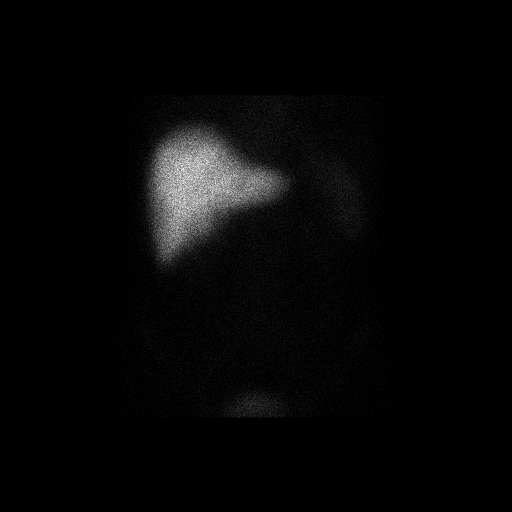

In [53]:
image

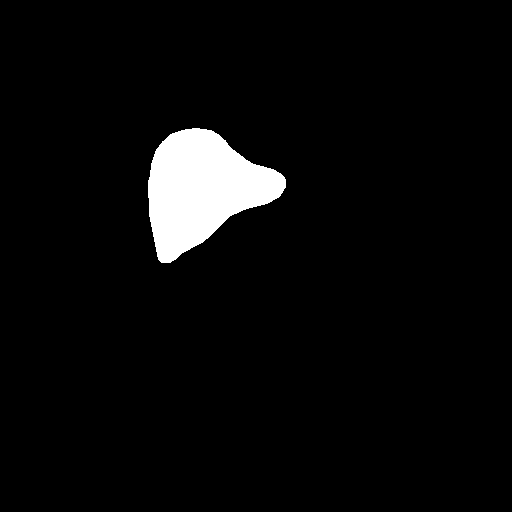

In [54]:
target

## UNet model

In [55]:
model = UNet(in_channels=3, out_channels=21)
print(model)

UNet(
  (in_conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (down1): _Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
          (3)

In [56]:
count_model_params(model)

17264277

## Accelerator

In [57]:
accelerator = Accelerator(cpu=False, mixed_precision="fp16")

## Обучаем модель

In [58]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 4
NUM_WORKERS = 2
EPOCH_NUM = 20
CHECKPOINTS_DIR = "checkpoints"
TENSORBOARD_DIR = "tensorboard"
RM_CHECKPOINTS_DIR = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [59]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)

model = UNet(in_channels=3, out_channels=21)

loss_fn = MulticlassCrossEntropyLoss(ignore_index=0)  # MulticlassDiceLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer, step_size=5, gamma=0.8
)
metric_fn = loss_fn

os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
checkpointer = CheckpointSaver(
    accelerator=accelerator,
    model=model,
    metric_name="DICE",
    save_dir=CHECKPOINTS_DIR,
    rm_save_dir=RM_CHECKPOINTS_DIR,
    max_history=5,
    should_minimize=True,
)

In [60]:
# !pip install tensorboard
# tensorboard_logger = None

os.makedirs(TENSORBOARD_DIR, exist_ok=True)
tensorboard_logger = torch.utils.tensorboard.SummaryWriter(log_dir=TENSORBOARD_DIR)

In [61]:
# акселерируем
model, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader, lr_scheduler
)

In [62]:
train(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_function=loss_fn,
    metric_function=metric_fn,
    lr_scheduler=lr_scheduler,
    accelerator=accelerator,
    epoch_num=EPOCH_NUM,
    checkpointer=checkpointer,
    tb_logger=tensorboard_logger,
    save_on_val=True,
)

  0%|          | 0/20 [00:00<?, ?it/s]

------------------------------
Epoch 0/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

AssertionError: Caught AssertionError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\Users\dev1ce\Documents\GitHub\segmentation\venv\Lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dev1ce\Documents\GitHub\segmentation\venv\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "C:\Users\dev1ce\Documents\GitHub\segmentation\segmentation\dataset.py", line 47, in __getitem__
    assert self.transforms is not None
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError


## Загрузим и протестируем обученную модель

In [ ]:
model = UNet(in_channels=3, out_channels=21)
model = load_checkpoint(
    model=model, load_path=pjoin(CHECKPOINTS_DIR, "model_checkpoint_best.pt")
)
model = model.to(DEVICE)
model.eval()

In [ ]:
sample_idx = 0
image, target = train_dataset[sample_idx]
target = torch.argmax(target, axis=0)
preds = torch.argmax(
    F.softmax(model(image.unsqueeze(0).to(DEVICE)), dim=1).squeeze(0), axis=0
)

fig, ax = plt.subplots(1, 3, figsize=(9, 18))
ax[0].imshow(image.numpy().transpose(1, 2, 0).astype(np.uint8))
ax[1].imshow(target.numpy())
ax[2].imshow(preds.cpu().numpy());